In [19]:
import sys
import os
sys.path.append(os.path.abspath("../src"))  # Adjust path if needed


In [ ]:
import numpy as np
import pandas as pd

# Load scaled multivariate data
df_scaled = pd.read_csv("../data/scaled_data.csv", index_col=0)
data = df_scaled.values

# Parameters
sequence_length = 30  # past 30 timesteps
n_features = data.shape[1]

# Convert timeseries to supervised format
def create_supervised_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length].flatten()) # Flatten multivariate seq
        y.append(data[i+sequence_length, 0])  # PM2.5 is the target
    return np.array(X), np.array(y)

X, y = create_supervised_dataset(data, sequence_length)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Random Forest - with faster settings
rf = RandomForestRegressor(
    n_estimators=50,        # fewer trees
    max_depth=10,           # limit tree depth
    n_jobs=-1,              # use all CPU cores
    random_state=42
)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# XGBoost - with faster settings
xgb = XGBRegressor(
    n_estimators=50,        # fewer trees
    learning_rate=0.1,
    max_depth=6,            # limit tree depth
    n_jobs=-1,              # use all CPU cores
    verbosity=1,            # show progress
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Reshape X for LSTM: (samples, timesteps, features)
X_train_lstm = X_train.reshape(-1, sequence_length, n_features)
X_test_lstm = X_test.reshape(-1, sequence_length, n_features)

train_dataset = TensorDataset(torch.tensor(X_train_lstm, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test_lstm, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

lstm_model = LSTMModel(input_size=n_features)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training
for epoch in range(10):  # can increase if needed
    for xb, yb in train_loader:
        pred = lstm_model(xb).squeeze()
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [12]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Manual square root
    r2 = r2_score(y_true, y_pred)
    print(f"{name}:\n  RMSE: {rmse:.4f}\n  R²:   {r2:.4f}\n")


In [13]:
# LSTM Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32).to(device)
lstm_model = lstm_model.to(device)
lstm_model.eval()

with torch.no_grad():
    lstm_preds = lstm_model(X_test_tensor).squeeze().cpu().numpy()
print("X_test_lstm:", X_test_lstm.shape)
print("y_test:", y_test.shape)
print("lstm_preds:", lstm_preds.shape)

evaluate_model("LSTM", y_test.squeeze(), lstm_preds)


X_test_lstm: (724, 30, 49)
y_test: (724,)
lstm_preds: (724,)
LSTM:
  RMSE: 1.1433
  R²:   -0.3489



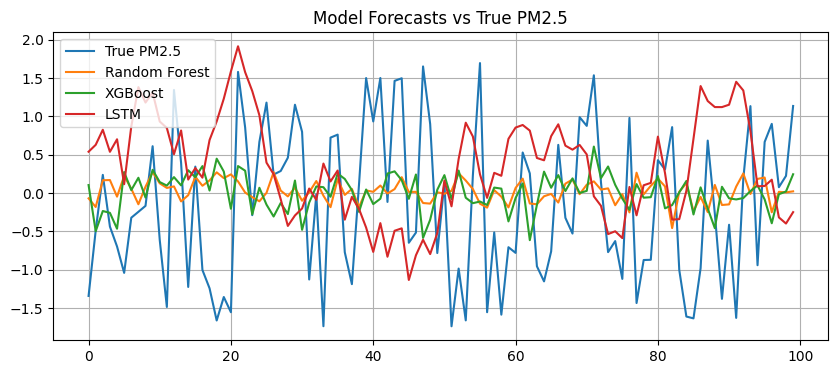

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_test[:100], label="True PM2.5")
plt.plot(rf_preds[:100], label="Random Forest")
plt.plot(xgb_preds[:100], label="XGBoost")
plt.plot(lstm_preds[:100], label="LSTM")
plt.title("Model Forecasts vs True PM2.5")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# Use these if you haven’t already
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)
evaluate_model("LSTM", y_test, lstm_preds)
evaluate_model("DDPM", y_test, ddpm_preds[:len(y_test)])  # if available


Random Forest:
  RMSE: 0.9958
  R²:   -0.0232

XGBoost:
  RMSE: 1.0205
  R²:   -0.0746

LSTM:
  RMSE: 1.1433
  R²:   -0.3489

DDPM:
  RMSE: 1065.3686
  R²:   -1171288.5629



In [25]:
# --- Load DDPM model ---
from diffusion_model import Simple1DDiffusionModel
import torch

ddpm_model = Simple1DDiffusionModel(seq_len=30)
ddpm_model.load_state_dict(torch.load("../models/pm25_diffusion_model.pth"))
ddpm_model.eval()

@torch.no_grad()
def sample_forecast(model, steps, input_dim, alpha=0.1):
    x = torch.randn(1, input_dim)  # Start from noise
    for t in reversed(range(steps)):
        noise = model(x)
        x = x - alpha * noise
    return x.squeeze().cpu().numpy()

# --- Match length with y_test ---
ddpm_preds = []
for _ in range(len(y_test)):
    pred = sample_forecast(ddpm_model, steps=100, input_dim=30, alpha=0.1)
    ddpm_preds.append(pred[0])  # PM2.5 forecast (index 0)

ddpm_preds = np.array(ddpm_preds)

# --- Evaluate ---
evaluate_model("DDPM", y_test, ddpm_preds)


DDPM:
  RMSE: 1058.9181
  R²:   -1157147.8825

